## Replicating a machine learning paper for computer vision


Referenced paper for vision transformer (ViT): https://arxiv.org/abs/2010.11929

## Get setup

Import code we have previously written and required libraries.

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 23.27 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data
We need some data, namely the pizza, steak, sushi images.

In [3]:
# 10% data
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Set up directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create datasets and dataloaders


In [5]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# Create img size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Create a batch size of 32 (the paper uses 4096 but that may be too big for our small storage)
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)



In [6]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [7]:
# Visualise a single image
# Get a batch
image_batch, label_batch = next(iter(train_dataloader))


# Get the first image and label
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

## Plot the image with matplot lib

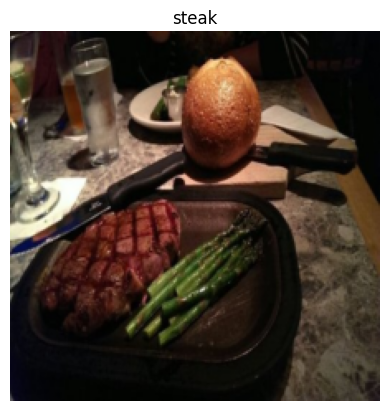

In [8]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # C,H,W to H,W,C
plt.title(class_names[label])
plt.axis(False);

## Replicating ViT: Overview

We break the paper down into smaller pieces:

* **Inputs** - What goes into the model? (image tensors)

* **Outputs** - What comes out of the model/layer/block (model to ouput image classification labels)

* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).

* **Blocks** - A collection of layers

* **Models** - A collection of blocks

## ViT overview
* Figure 1: Visual overview of the architecture
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)




* Four equations: math equations defining the functions of each layer/block
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... , image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos ... , image_patch_N_pos]
```

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input # residual connection

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

MLP - Multilayer perceptron = a neural network with X number of layers

```python
# Equation 4
y = Linear_Layer(LN_layer(x_output_MLP_block))
```



* Table 1/3: different hyperparameters for the architecture/training
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture

* Layers - number of transformer encoder layers

* Hidden size $D$ - the embedding size throughout the architecture

* MLP size - number of hidden units / neurons within the MLP

* Heads - number of multi-head self-attention

ViT-B/16 means base model ViT with patch size 16 x 16

## Equation 1: Split data into patches and creating the class, position and path embedding

Layers = input -> function -> output

Whats the input shape?
* Input shape: (224, 224, 3) -> single image, H, W, C

Whats the output shape?


* Input shape: H x W x C

* Output shape: N x P dot_product P

* H = Height

* W = Width

* C = colour channels

* P = patch size

* N = number of patches = (H x W) / (p^2)

* D = constant latent vector size = embedding dimension (see table 1)

In [9]:
# Example values
height = 224
width = 224
colour_channels = 3
patch_size = 16

# Calculate the number of patches

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
# Input shape
embedding_layer_input_shape = (height, width, colour_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * colour_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


## Turn a single image into patches

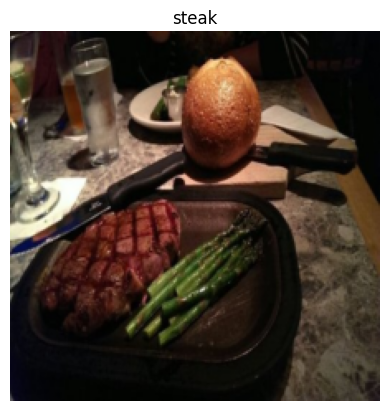

In [11]:
# View a single image

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [12]:
image.shape

torch.Size([3, 224, 224])

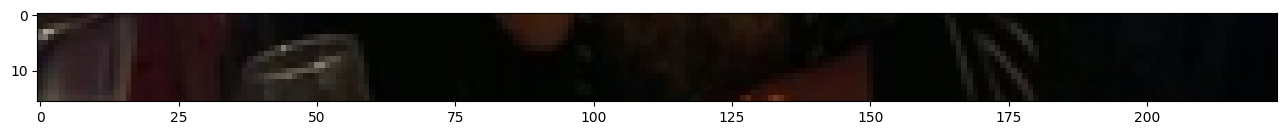

In [13]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert to H,W,C for matplotlib

# Index to plot the top row of pixels
patch_size = 16

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

''

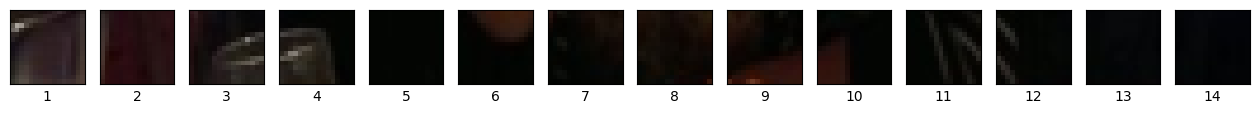

In [14]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "image size must be divisible by patch size"

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patcb
                        sharex=True, # share axis?
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])
;

''

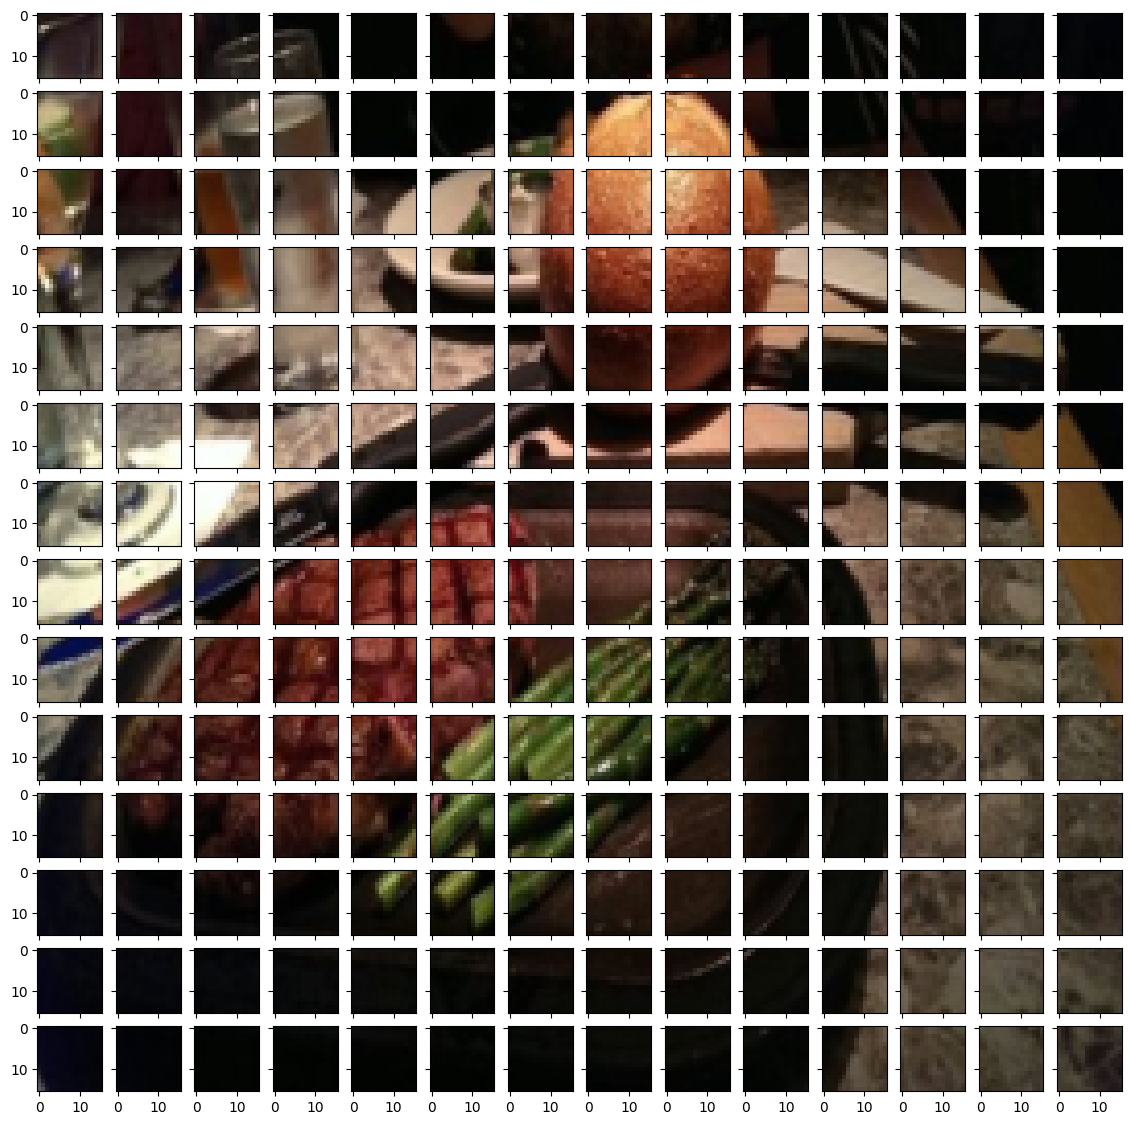

In [15]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "image size must be divisible by patch size"

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches,num_patches),
                        sharex=True,
                        sharey=True)


# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
    axs[i, j]
;

## Creating image patches and turning them into patch embeddings

We can create the image patches by using nn.Conv2d() and set the kernel size to patch size (16 x 16) and the stride as 16, giving convolutional feature maps (learnable features) for each patch (known as embedding now)

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set patch size
patch_size = 16

# Create conv2d layer
conv2d = nn.Conv2d(in_channels=3, # colour channels
                   out_channels=768, # D size from table 1
                   kernel_size=patch_size, # will be set to (patch_size, patch_size)
                   stride=patch_size, # same here
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

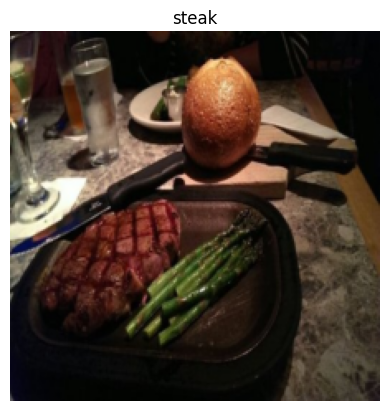

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass image through conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension so now batchsize, C, H, W
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


We have passed a single image to our `conv2d` layer, its shape is:

```python
torch.Size([1, 768, 14, 14]), batch_size, embedding_dim, feature_map_height, feature_map_width # We get 768 14 x 14 feature maps
```

Showing random convolutional feature maps from indexes: [306, 192, 402, 85, 276]


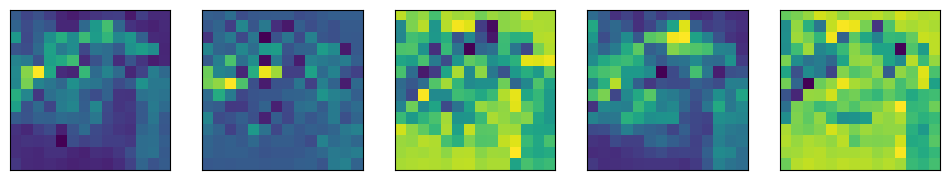

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dim, remove grad tracking and move to numpy
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0587,  0.0380,  0.0766,  0.0438,  0.0350, -0.0178,  0.0317,
            0.0186,  0.0481,  0.0612,  0.0435,  0.0618,  0.0371,  0.0439],
          [ 0.0749,  0.0477,  0.1320, -0.0106,  0.0375,  0.0613,  0.0908,
           -0.0957, -0.0557,  0.0733,  0.0446,  0.0417,  0.0300,  0.0396],
          [ 0.0450,  0.0357,  0.0263,  0.0717,  0.0961,  0.0095,  0.1432,
           -0.0505, -0.0046,  0.0690,  0.0754,  0.0440,  0.0421,  0.0366],
          [ 0.0172,  0.0062,  0.0678,  0.0990,  0.0820,  0.1576, -0.0709,
           -0.0714, -0.0749, -0.0743,  0.0488,  0.0648,  0.0659,  0.0362],
          [ 0.1291,  0.0382,  0.0794,  0.1129,  0.1414,  0.1553, -0.0016,
            0.0150, -0.0088, -0.0928,  0.0195,  0.0090,  0.0285,  0.0600],
          [ 0.0590,  0.0551,  0.1601,  0.0060, -0.1079,  0.1076, -0.0290,
            0.0662,  0.1682,  0.0203,  0.0645,  0.0782,  0.1366,  0.0412],
          [ 0.1027,  0.0465,  0.2252,  0.1894,  0.0988,  0.0571,  0.0339,
            0.0113,  0.0285,  0.

## Flatten the 2 dimensions of the feature map (patch embedding) into a sequence

Right now we got a series of conv feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the criteria of the ViT transformer encoder.


In [21]:
print(f"shape after conv layer: {image_out_of_conv.shape}") # -> batch_size, embedding_dim, feature_map_height, feature_map_width

shape after conv layer: torch.Size([1, 768, 14, 14])


want: batch_size, number_of_patches, embedding_dim   # i.e. 1, 196, 768

In [22]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3) # dim are zero indexed

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


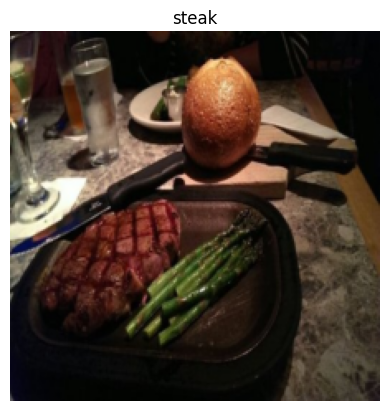

In [23]:
# Put everything together

# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Finally permute
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
image_out_of_conv_flattened.shape # -> batch size, number of patches, embedding dimensions

torch.Size([1, 768, 196])

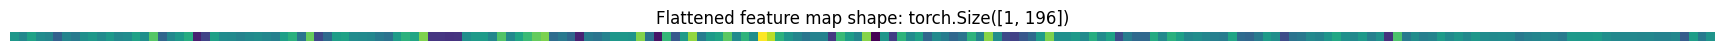

In [25]:
# Get single flattened feature map (1 embedding)
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

## Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize appropriate hyperparameters
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps
5. Define a `forward()` that defines the forward computation
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [26]:
# Create a class
class PatchEmbedding(nn.Module):
  # Initialise the layer with hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # From table 1 of paper
    super().__init__()

    self.patch_size = patch_size

    # Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
    # Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # Define forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1] # get last dim
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image_shape: {image_resolution}, patch_size: {self.patch_size}"

    # Forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # Permute the x_flattened (batch size, number of patches, embedding dim)
    return x_flattened.permute(0, 2, 1)

In [27]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through the layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [28]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

## Create the class token embedding

1. Prepend a learnable class token to the start of the patch embedding

In [29]:
patch_embedded_image.shape # after prepending to the start, should be 1, 197, 768

torch.Size([1, 196, 768])

In [30]:
# Get batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1] # last dim
batch_size, embedding_dimension

(1, 768)

In [31]:
# Create the class token embedding as a learnable parameter that shares the same size as the embedding dim (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make it learnable

class_token.shape

torch.Size([1, 1, 768])

In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), # tensor concatenation
                                                      dim=1) # along which dim?
patch_embedded_image_with_class_embedding # check for learnability as well + look if the ones tensor at the front

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2219,  0.0091, -0.0890,  ...,  0.1649, -0.1090,  0.0569],
         [-0.1013, -0.0246, -0.0188,  ...,  0.0522, -0.0791,  0.0524],
         ...,
         [-0.2437,  0.0573, -0.0667,  ...,  0.1920, -0.1272,  0.0842],
         [-0.2986,  0.0253, -0.0815,  ...,  0.2077, -0.1146,  0.0922],
         [-0.1498,  0.0034, -0.1009,  ...,  0.1006, -0.1041,  0.1337]]],
       grad_fn=<CatBackward0>)

In [33]:
patch_embedded_image_with_class_embedding.shape # shape of the new batch sequence with the prepended class token

torch.Size([1, 197, 768])

## Creating the positional embedding

Want to create a series of 1D learnable position embeddings and to add them to the sequence of patch + class token embeddings

In [34]:
# View of sequence of patch embeddings with prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2219,  0.0091, -0.0890,  ...,  0.1649, -0.1090,  0.0569],
          [-0.1013, -0.0246, -0.0188,  ...,  0.0522, -0.0791,  0.0524],
          ...,
          [-0.2437,  0.0573, -0.0667,  ...,  0.1920, -0.1272,  0.0842],
          [-0.2986,  0.0253, -0.0815,  ...,  0.2077, -0.1146,  0.0922],
          [-0.1498,  0.0034, -0.1009,  ...,  0.1006, -0.1041,  0.1337]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

# Get embedding dimensions
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1] # last dim

# Create the learnable 1D posion embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [36]:
# Add position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

patch_and_position_embedding, patch_and_position_embedding.shape # check if the class token of 1 has changed to 2 after the addition

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7781, 1.0091, 0.9110,  ..., 1.1649, 0.8910, 1.0569],
          [0.8987, 0.9754, 0.9812,  ..., 1.0522, 0.9209, 1.0524],
          ...,
          [0.7563, 1.0573, 0.9333,  ..., 1.1920, 0.8728, 1.0842],
          [0.7014, 1.0253, 0.9185,  ..., 1.2077, 0.8854, 1.0922],
          [0.8502, 1.0034, 0.8991,  ..., 1.1006, 0.8959, 1.1337]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

## From image to embedding

In [37]:
# Set seed
set_seeds()

# Set patch size
patch_size = 16

# Print shapes of the original image and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add a batch dim
x = image.unsqueeze(dim=0)
print(f"Input image shape: {x.shape}")

# Create the patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape; {patch_embedding.shape}")

# Prepend the class token to the sequence of patch embeddings
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1 , embedding_dimension),
                           requires_grad=True) # learnable
print(f"Class token embedding shape: {class_token.shape}")

# Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape; torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA)

* MSA: Which part of a sequence should pay the most attention to itself (and hence "self" attention)
  * In our case, we have a series of embedded patches, which patch significantly relates to another patch
  * We want our ViT to learn this relationship/representation so hopefully it can learn what is a good representation of what is inside a image

* PyTorch has inbuilt MSA
* LayerNorm is a technique to normalize the distributions of intermediate layers, enables faster training, and better generalisation accuracy
  * Normalize = make everything have the same mean and standard deviation
  * In PyTorch, normalize over the $D$ dimension, the embedding dimension.
  * Like having a stairs in a staircase the same size.
  

In [38]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi=head self-attention block ("MSA block" for short).
  """

  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1 for ViT-Base
               num_heads:int=12, # Heads from table 1 for ViT-Base
               attn_dropout:float=0):
    super().__init__()

    # Create the Norm Layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention layer (MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch first? (batch,seq,feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x): # the query, key, value is all the same (Self attention)
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x, # can put underscore and ignore the weights output
                                      key=x,
                                      value=x,
                                      need_weights=False)
    return attn_output # we will implement the skip connection later

In [39]:
# Create instance of MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [40]:
patched_image_through_msa_block

tensor([[[-0.1432, -0.0537,  0.0476,  ..., -0.3806,  0.8179, -0.4279],
         [-0.1309, -0.0431,  0.0747,  ..., -0.3629,  0.8350, -0.4339],
         [-0.1295, -0.0647,  0.0555,  ..., -0.3690,  0.8306, -0.4568],
         ...,
         [-0.1253, -0.0416,  0.0622,  ..., -0.3756,  0.8368, -0.4444],
         [-0.1157, -0.0379,  0.0614,  ..., -0.3831,  0.8393, -0.4411],
         [-0.1102, -0.0429,  0.0705,  ..., -0.3833,  0.8358, -0.4407]]],
       grad_fn=<TransposeBackward0>)

## Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch called `torch.nn.Linear()`, in TensorFlow `tf.keras.layers.Dense()`
  * GELU is a non-linear activation
  * MLP number of hidden units = MLP Size in Table 1
  * Dropout is applied after every dense (linear) layer in MLP (value in table 3)


In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> non-linear -> dropout
```

In [41]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()


    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout))

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [42]:
# Create instance
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSABlock into MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [43]:
patched_image_through_msa_block

tensor([[[-0.1432, -0.0537,  0.0476,  ..., -0.3806,  0.8179, -0.4279],
         [-0.1309, -0.0431,  0.0747,  ..., -0.3629,  0.8350, -0.4339],
         [-0.1295, -0.0647,  0.0555,  ..., -0.3690,  0.8306, -0.4568],
         ...,
         [-0.1253, -0.0416,  0.0622,  ..., -0.3756,  0.8368, -0.4444],
         [-0.1157, -0.0379,  0.0614,  ..., -0.3831,  0.8393, -0.4411],
         [-0.1102, -0.0429,  0.0705,  ..., -0.3833,  0.8358, -0.4407]]],
       grad_fn=<TransposeBackward0>)

In [44]:
patched_image_through_mlp_block # check if values changed

tensor([[[ 0.0372, -0.0083,  0.0933,  ..., -0.0000, -0.1068,  0.2385],
         [ 0.0349, -0.1132,  0.2143,  ..., -0.1222, -0.1093,  0.2396],
         [ 0.0899, -0.0783,  0.2250,  ..., -0.0000, -0.1678,  0.2151],
         ...,
         [-0.0819, -0.0118,  0.2082,  ...,  0.0607, -0.1788,  0.3187],
         [-0.0185,  0.0561,  0.0000,  ...,  0.0483, -0.1438,  0.1062],
         [ 0.0241, -0.0114,  0.1953,  ..., -0.1412, -0.1229,  0.2388]]],
       grad_fn=<MulBackward0>)

## Creating the transformer encoder
The transformer encoder is an alternating layers of MSA and MLP blocks for L times + need to implement residual connection

**Encoder** = turn a sequence into a learnable representation
**Decoder** = go from learnt representation to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (preventing the weights from becoming too small)

In pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

In [45]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # D from table 1
               num_heads:int=12, # table 1
               mlp_size:int=3072, # table 1
               mlp_dropout:float=0.1, # table 3
               attn_dropout:float=0):
    super().__init__()

    # Create MSA block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)

    # Create MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual connection (aka skip connection)
    x = self.mlp_block(x) + x # residual connection again
    return x

In [46]:
# Create an instance
transformer_encoder_block = TransformerEncoderBlock()

# Get summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # batch size, num of patches, embedding dimension
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Create a Transformer Encoder layer with inbuilt PyTorch layers

So far we created a transformer encoder by hand

But because of how good the architecture is, PyTorch has implemented ready to use Transformer Encoder layers

In [47]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformed_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size
                                                             nhead=12, # head from table 1
                                                             dim_feedforward=3072, # mlp size
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True) # normalise before MSA?

In [48]:
torch_transformed_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [49]:
# Get summary using torchinfo.summary
summary(model=torch_transformed_encoder_layer,
        input_size=(1, 197, 768), # batch size, num of patches, embedding dimension
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Now we know how to replicate architectures from machine learning papers

But using pre-built pytorch layers are better:
* Less prone to errors
* Potentially better performance


## Putting it all together to create ViT

In [50]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:float=0.0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # Number of classes in our classification problem
    super().__init__()

    # Make an assertion that image size is compatible with patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable positional embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, # * means all
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head (equation 4)
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to infer the dimensions

    # Create the patch embedding (eqn 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (eqn 1)
    x = torch.cat((class_token, x), dim=1) # batch_size, number_of_patches, embedding_dim

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to transformer encoder (eqn 2 + 3)
    x = self.transformer_encoder(x)

    # Put the 0th index logit through the classifier (eqn 4)
    x = self.classifier(x[:, 0]) # get all the batches

    return x

In [51]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [52]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create instance of ViT with number of classes of 3
vit = ViT(num_classes=3)

# Pass random tensor into vit
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## Getting a visual summary of our ViT model

In [53]:
# Get summary using torchinfo.summary
summary(model=ViT(num_classes=3),
        input_size=(1, 3, 224, 224), # batch_size, colour_channels, H, W
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVisionMini data

# Create a loss function and optimizer

The paper uses the Adam optimizer with $B1$ value of 0.9, $B2$ value of 0.999 (defaults) and a weight decay of 0.1.

Weight decay is a regularization technique (prevent overfitting) by adding a small penalty (to the weights).



ViT paper does not mention what loss function they used. Since its a multi-class classification, we will use `torch.nn.CrossEntropyLoss()`

## Training the ViT model

In [54]:
from going_modular.going_modular import engine

set_seeds()
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


## What our training setup is missing

How is our training setup different to the ViT paper?

What is different in our training procedures?

Prevent underfitting:
1. Scale of data (more data = very good for deep learning models) (225 vs millions)
2. Number of epochs

Prevent overfitting:
3. Learning rate warmup - start with a low rate and increase to a big LR
4. Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
5. Gradient clipping - prevent gradients from getting too big

3, 4 and 5 help to improve regularization (prevent overfitting)

Right now underfitting more than it is overfitting, so usually u try to get it to overfit first then prevent the overfitting

## Plotting loss curves for our model

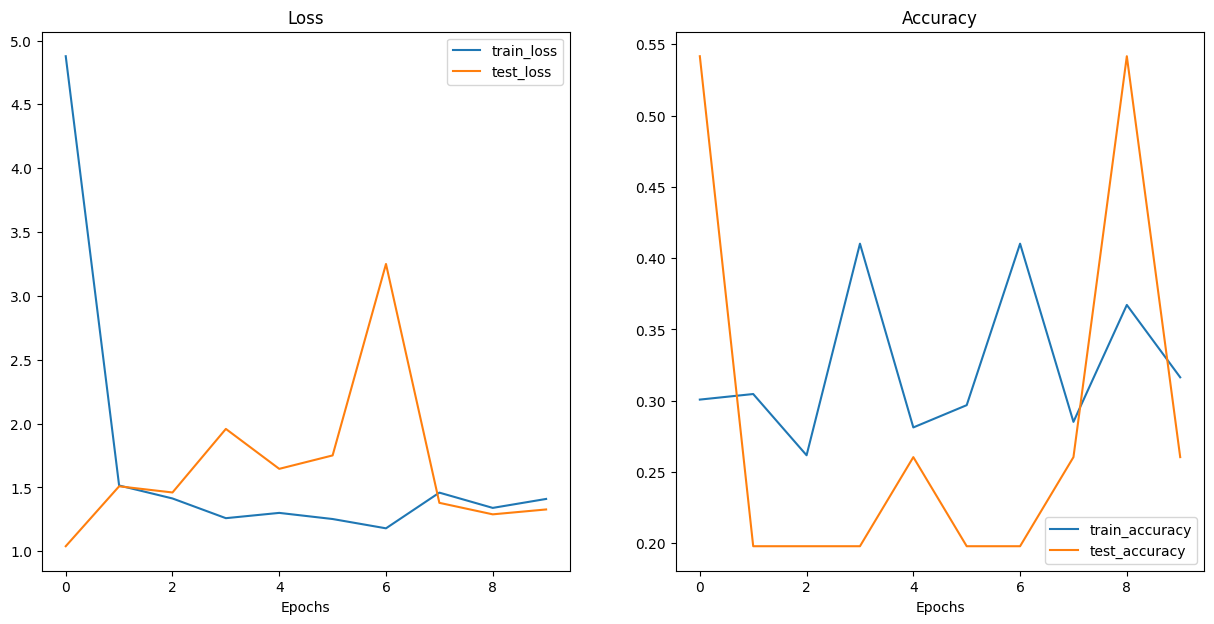

In [55]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## Model is both underfitting and overfitting, transfer learning can help to deal with both

## Using a pretrained ViT from `torchvision.models`

Generally in deep learning, if you can use a pretrained model from a large dataset on your own problem, it is a good place to start.
If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results.

**Why use a pretrained model?**
Data is limited, limited training resources, get better results faster

In [56]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [81]:
# Get pretrained weights for vit_b_ 16
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # Best available weights

# Setup model instance
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

In [82]:
# Get summary using torchinfo.summary
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # batch_size, colour_channels, H, W
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [83]:
# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [84]:
# Get summary using torchinfo.summary
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # batch_size, colour_channels, H, W
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Exact same as the custom vit we built except trainable parameters for pretrained vit is much smaller than the custom vit (where everything is trainable)

## Preparing data for pretrained vit model

When using a pretrained model, ensure that your data is formatted in the same way the pretrained model was trained on.

In [85]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [87]:
# Set up dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model since only have fewer trainable parameters (updatable weights)


In [88]:
## Train feature extractor ViT model
from going_modular.going_modular import engine

# Create optimizer and loss_fn
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


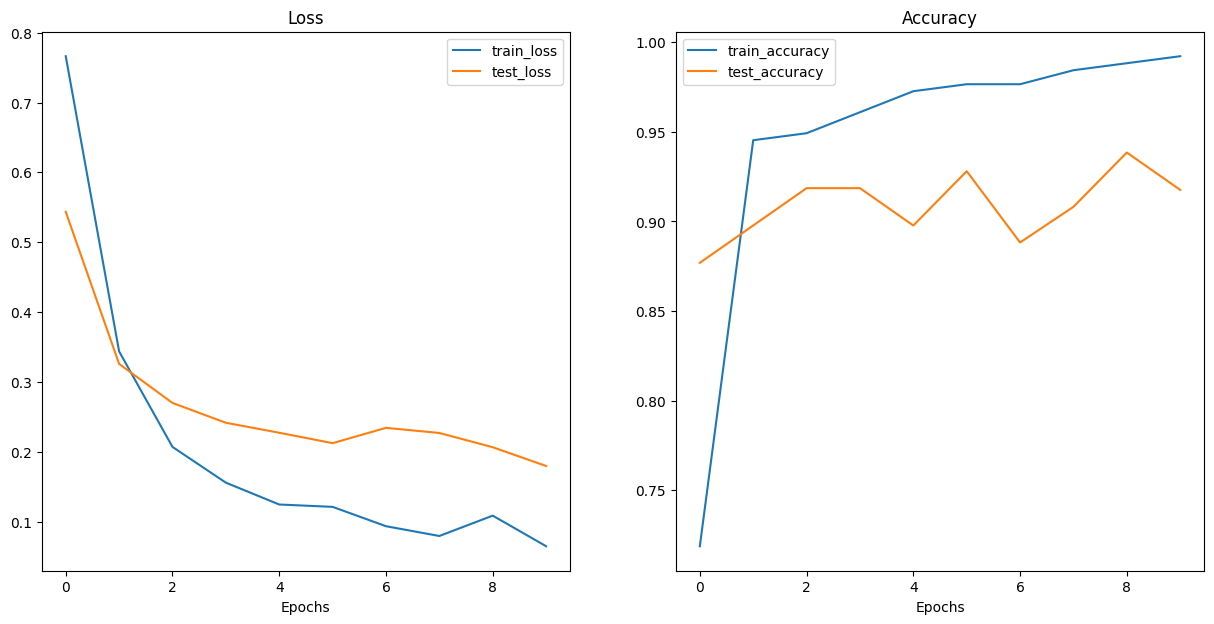

In [89]:
# Plot loss curves of pretrained vit
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## Save the best performing ViT model

Now we got a model that performs quite well, save it to file and check its filesize.

Need to check filesize because if we wanted to deploy a model to say a website/mobile application, we may have limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions

In [90]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [93]:
from pathlib import Path

# Get model size in bytes then convert to MB
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)

pretrained_vit_model_size # in MB

327

Our pretrained ViT gets some of the best results we have seen so far on our FoodVisionMini problem but the model size is 11x bigger
than the next best preforming model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g. hard to deploy such a large file / slow predictions)

## Predicting on a custom image

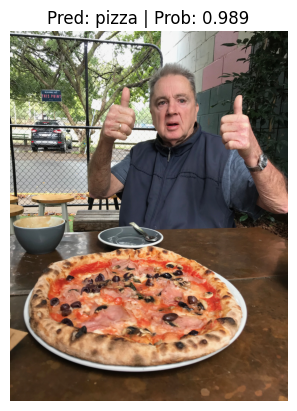

In [94]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)